# Import

In [42]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [43]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
from pytorch_metric_learning.utils import loss_and_miner_utils as lmu
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime

import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

logging.getLogger().setLevel(logging.INFO)

In [44]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
%autoreload 2

In [46]:
from src import params
from src.dataset import (get_transforms, get_cub_2011, get_cub_2011_class_disjoint, get_inverse_transform)
from src.models import (get_embedder, get_trunk)
from src.training import (get_optimizers, get_loss, get_miner, get_sampler, get_testing_hooks)
from src.utils import get_experiment_id, git_version
from src.evaluation import get_inference_model, get_scores, get_embeddings

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
print("Git commit hash", git_version())

Git commit hash 84513202436ad7049816b41d5f2ebead33c21dda


# Prepare dataset and model base classes

In [49]:
train_transform, val_transform = get_transforms()

In [50]:
original_train, original_val = get_cub_2011()

In [51]:
train_dataset, val_dataset = get_cub_2011_class_disjoint(train_transform, val_transform)

In [52]:
trunk, trunk_output_size = get_trunk(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)

# Load model

In [53]:
embedder_path, trunk_path = ('experiment_logs/10-15_18:21_embedding_regularizer/embedder_best15.pth',
 'experiment_logs/10-15_18:21_embedding_regularizer/trunk_best15.pth')

In [54]:
trunk, trunk_output_size = get_trunk(device)
trunk.load_state_dict(torch.load(trunk_path))
trunk = trunk.to(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)
embedder.load_state_dict(torch.load(embedder_path))
embedder = embedder.to(device)

In [55]:
gallery_dataset = original_train
query_dataset = original_val
gallery_dataset.transform = val_transform
query_dataset.transform = val_transform

gallery_labels = np.array([gallery_dataset.target(i) for i in range(len(gallery_dataset))])
query_labels = np.array([query_dataset.target(i) for i in range(len(query_dataset))])

In [56]:
inference_model = get_inference_model(trunk, embedder)

In [57]:
# gallery_images = torch.stack([gallery_dataset[i][0] for i in trange(len(gallery_dataset))])
# query_images =  torch.stack([query_dataset[i][0] for i in trange(len(query_dataset))])

In [58]:
gallery_embeddings = get_embeddings(inference_model, gallery_dataset)
query_embeddings = get_embeddings(inference_model, query_dataset)

100%|██████████| 5794/5794 [00:34<00:00, 170.29it/s]


In [59]:
inference_model.indexer.train_index(gallery_embeddings.cpu().numpy())

## Visual evaluation

In [60]:
inv_normalize = get_inverse_transform()

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset

In [61]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [62]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

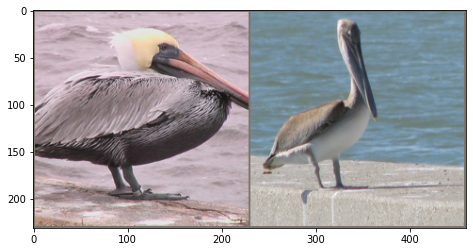

Different class


In [63]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

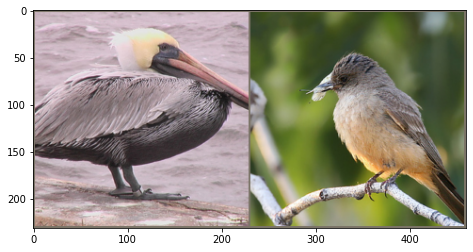

Different class


In [64]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)

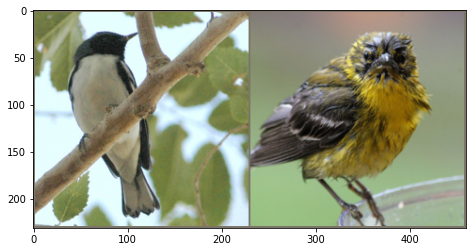

Different class
Actually different


In [71]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, x_label), (y, y_label) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0).to(device), y.unsqueeze(0).to(device))
print_decision(decision)
print('Actually same' if x_label==y_label else "Actually different")

## Retrieval

In [72]:
trunk = trunk.to('cpu')

In [73]:
embedder = embedder.to('cpu')

In [74]:
np.where(gallery_labels==136)

(array([4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087,
        4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098,
        4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106]),)

distances [[1.2898406e-12 4.7372088e-02 6.9943100e-02 1.3971655e-01 1.5611599e-01]]


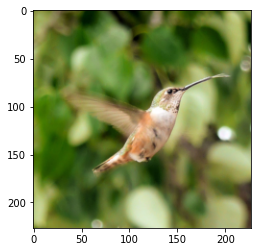

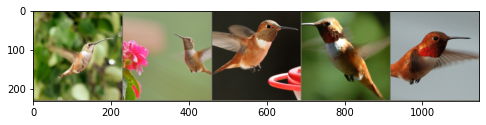

Query label 68
Neighbor labels [68 68 68 68 68]


In [79]:
k = 5
query_idx = np.random.randint(0, len(gallery_dataset))
#query_idx = 4226 # hardest class
#query_idx = 4080 # class 136, very hard
#query_idx = 2070 # easiest class
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print('distances', D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

# Pairwise distances

In [80]:
def get_pairwise_distances(embeddings, labels, sample_size=1000):
    same_label_distances = {}
    diff_label_distances = {}

    def get_label_vectors(label):
        label_indices = np.array(range(len(labels)))[labels == label]
        vectors = [embeddings[i].numpy() for i in label_indices]    
        return vectors

    for label in tqdm(set(gallery_labels)):
        vectors = get_label_vectors(label)

        distances = pdist(vectors, metric='cosine')
        same_label_distances[label] = distances

        diff_labels = list(set(labels).difference(set([label])))
        other_label = np.random.choice(diff_labels)
        other_vectors = get_label_vectors(other_label)

        other_distances_matrix = cdist(vectors, other_vectors)
        other_distances = []
        # Get upper triangle of matrix
        for i in range(len(other_distances_matrix)-1):
            other_distances.append(other_distances_matrix[i][i+1:])
        other_distances = np.concatenate(other_distances)

        diff_label_distances[(label, other_label)] = other_distances
        
    random_indices = np.random.choice(range(len(labels)), sample_size)
    random_distances = pdist(embeddings[random_indices].numpy(), metric='cosine')
    
    all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
    all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])
    
    return random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances


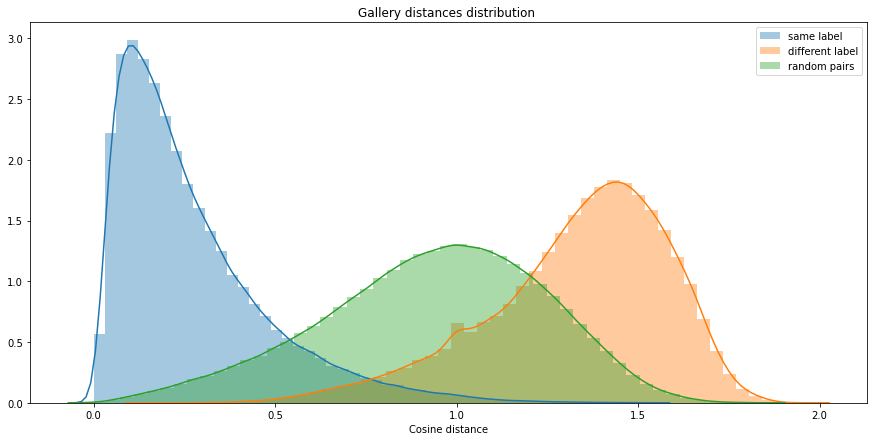

In [81]:
random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances = get_pairwise_distances(gallery_embeddings, gallery_labels)
plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine distance')
plt.title("Gallery distances distribution ")
plt.legend()
plt.show()

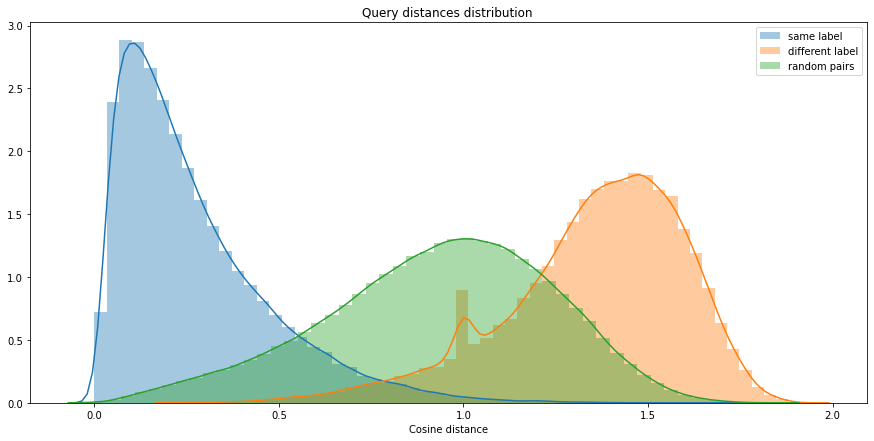

In [82]:
random_distances, all_same_label_dists, all_diff_label_distances, same_label_distances, diff_label_distances = get_pairwise_distances(query_embeddings, query_labels)
plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine distance')
plt.title("Query distances distribution ")
plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


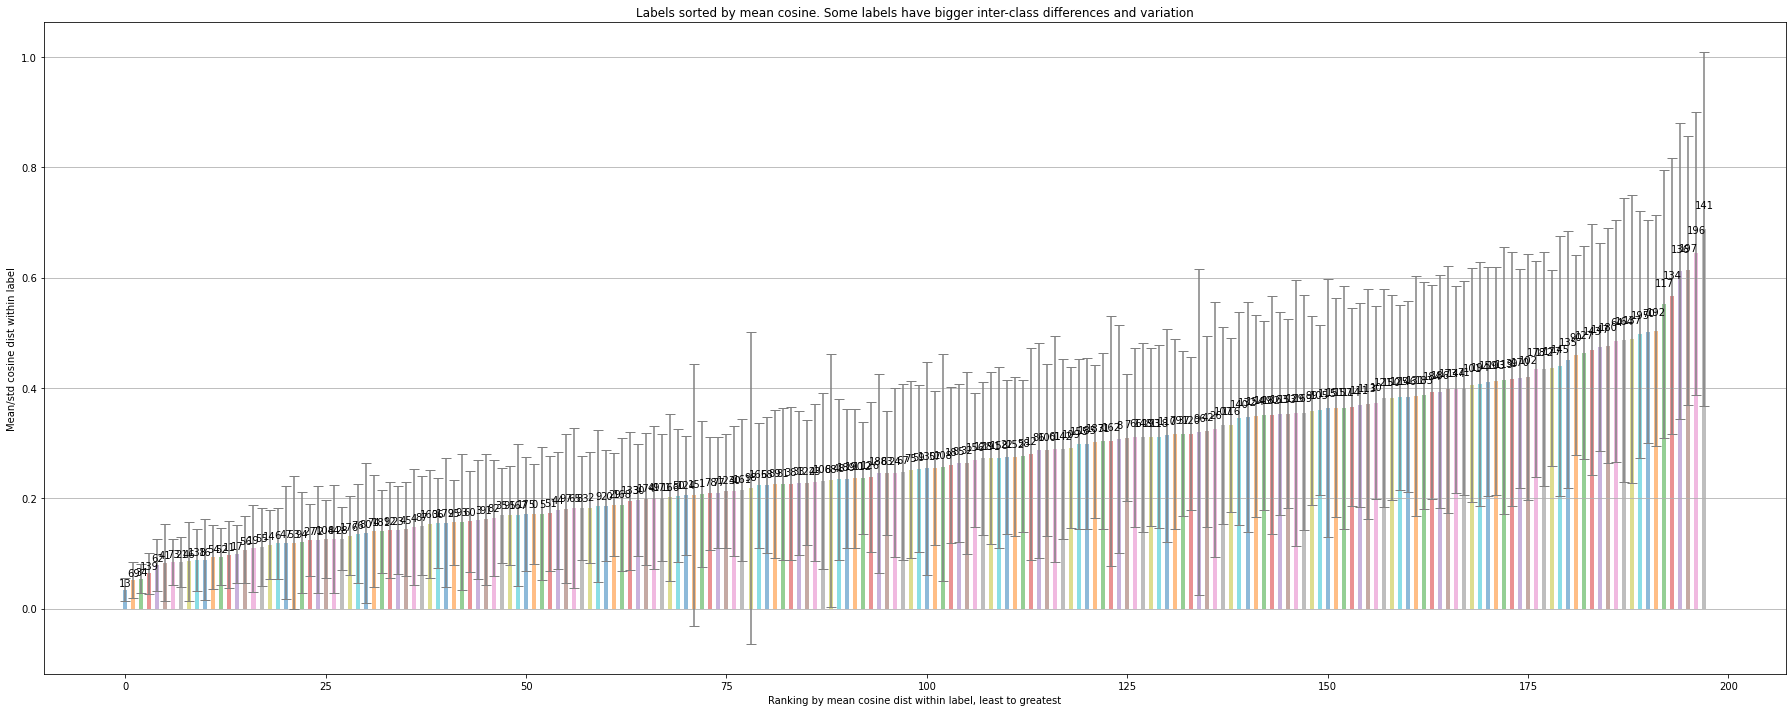

In [83]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 10))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()

Large inter-class distances == worse predictions

# Umap

In [84]:
plotting_transform = transforms.Compose([
    get_inverse_transform(),
    transforms.ToPILImage(),
    transforms.Resize(30),
])


def plot_umap(dataset, embeddings, labels):
    reducer = umap.UMAP()
    reduced = reducer.fit_transform(embeddings)
    
    str_labels = np.array(list(map(lambda x: 'l'+x, labels.astype(str))))
    
    reduced_x = reduced[:, 0]
    reduced_y = reduced[:, 1]
    
    #plt.scatter(x=reduced_x[:1], y=reduced_y[:1])
    
    _, uniq_label_idx = np.unique(labels, return_index=True)
    for ix, i in enumerate(uniq_label_idx):
        img, label = dataset[i]
        img = plotting_transform(img)
        npimg = np.array(img)
        
        if ix+1 < len(uniq_label_idx):
            x, y = reduced_x[i:uniq_label_idx[ix+1]].mean(), reduced_y[i:uniq_label_idx[ix+1]].mean()
        else:
            x, y = reduced_x[i:].mean(), reduced_y[i:].mean()
        
        
        ab = AnnotationBbox(OffsetImage(npimg), (x, y), frameon=False)
        ax = plt.gca()
        ax.add_artist(ab)
        
    sns.scatterplot(x=reduced_x, y=reduced_y, hue=str_labels, legend=False, alpha=0.3)
    
    

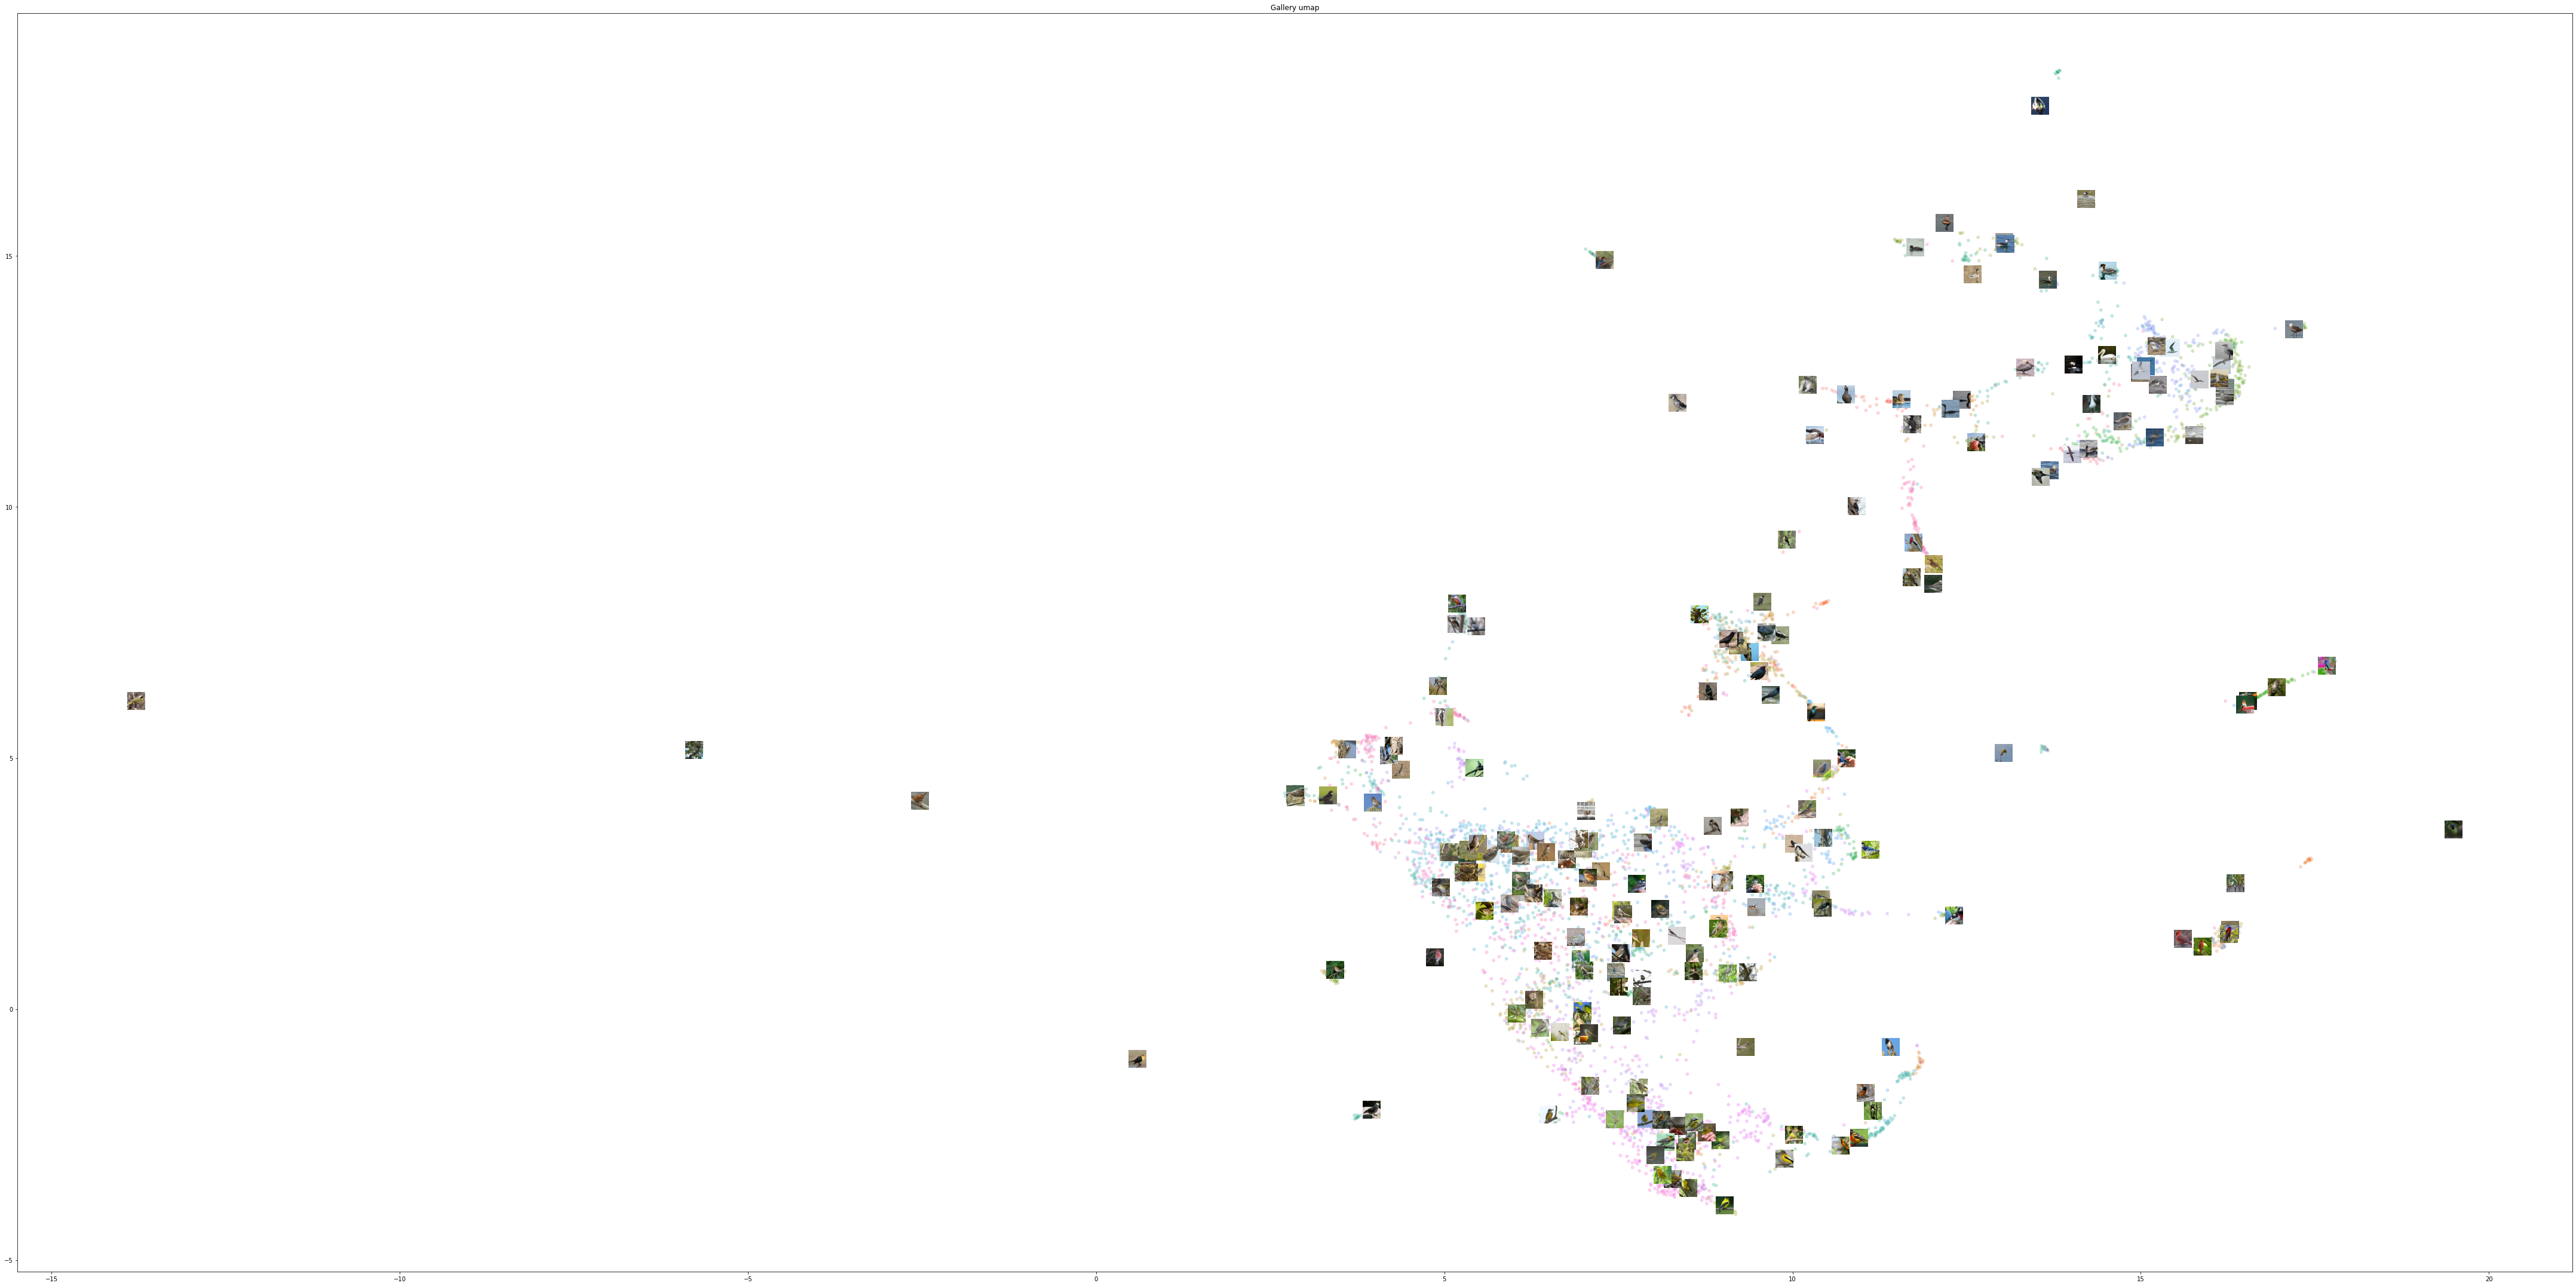

In [85]:
plt.figure(figsize=(60, 30))    
plot_umap(gallery_dataset, gallery_embeddings, gallery_labels)
plt.title("Gallery umap")
plt.tight_layout()
plt.show()

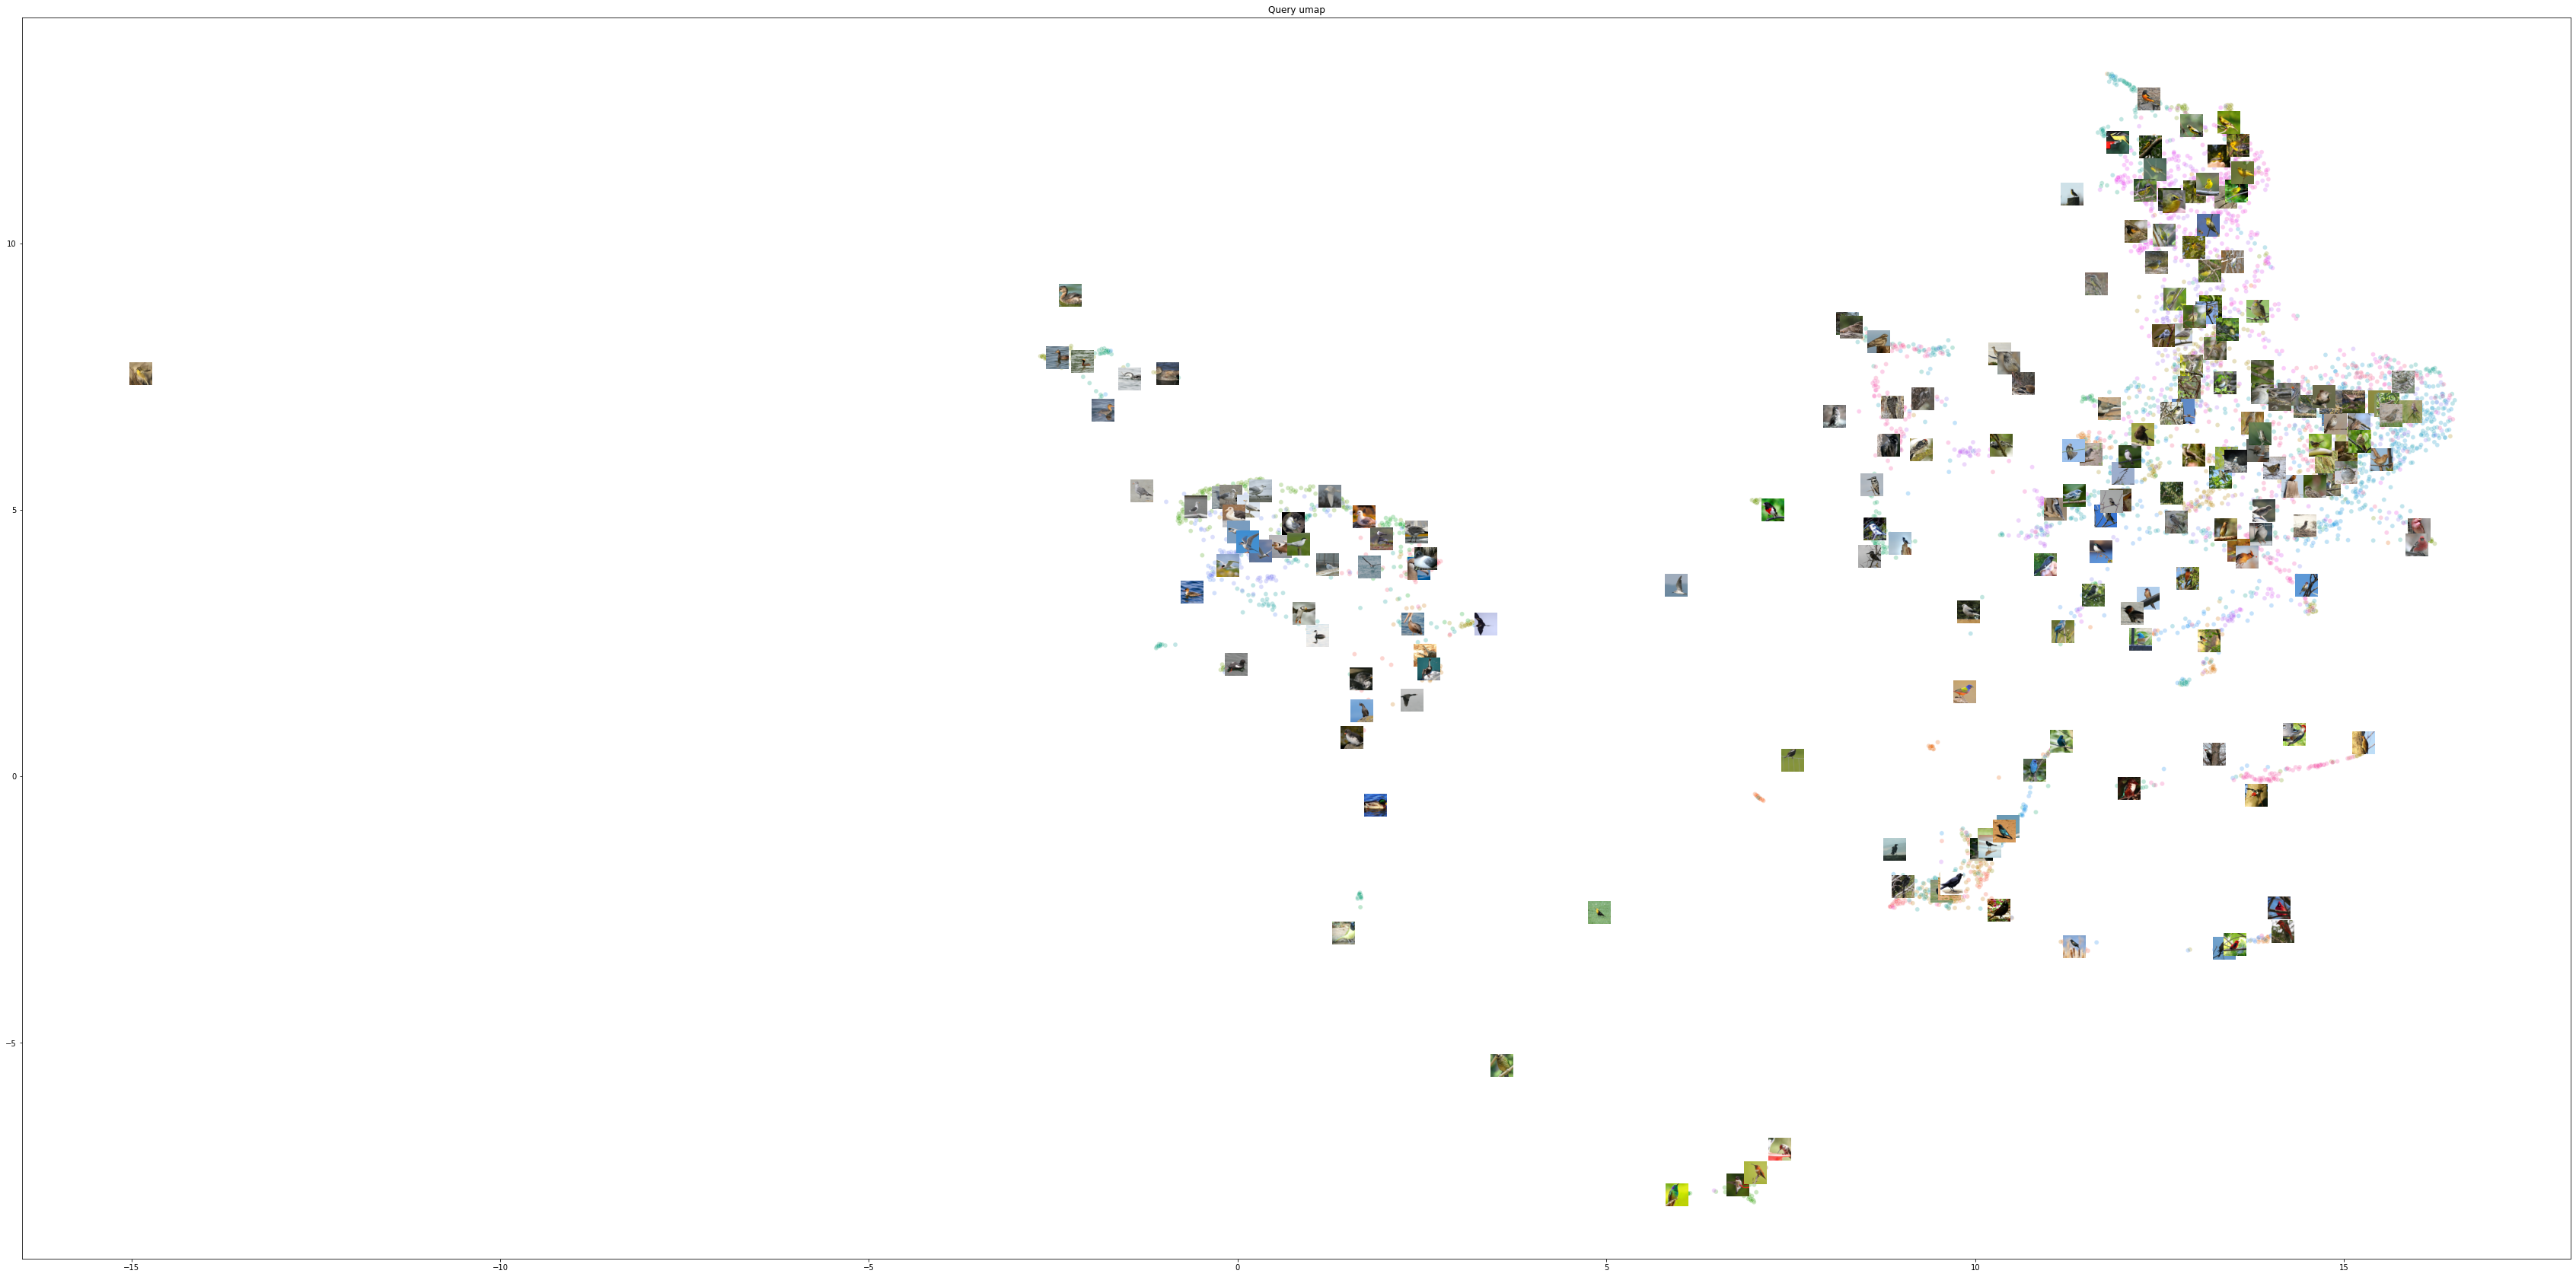

In [86]:
plt.figure(figsize=(60, 30))    
plot_umap(query_dataset, query_embeddings, query_labels)
plt.title("Query umap")
plt.show()